In [17]:
%matplotlib inline

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

from keras.models                      import Model
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [20]:
limit_mem()

In [21]:
def create_title(category, proba):
    return '"%s" %.1f%% confidence' % (category.replace('_', ' '), proba * 100) 

In [22]:
def generate_title(model, array):
    prediction = model.predict(array)
    _, category, proba = decode_predictions(prediction)[0][0]
    
    return create_title(category, proba)

In [35]:
filename = 'images1/spoonbill.jpg'

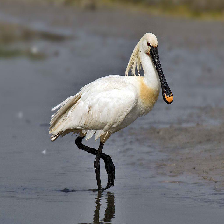

In [36]:
original_pic   = Image.open(filename).resize((224, 224))
original_array = np.expand_dims(np.array(original_pic), 0)
original_pic

In [37]:
imagenet_mean      = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess         = lambda x: (x - imagenet_mean)[:, :, :, ::-1]
deprocess          = lambda x: (x[:, :, :, ::-1] + imagenet_mean)
preprocessed_array = preprocess(original_array)
model              = VGG16()

In [38]:
pred = model.predict(preprocessed_array)
print(*[p[1:] for p in decode_predictions(pred)[0]], sep = '\n')

('spoonbill', 0.9997794)
('pelican', 0.0001523323)
('American_egret', 2.8326158e-05)
('dowitcher', 1.2328913e-05)
('goose', 8.31352e-06)


In [39]:
target_idx      = model.predict(original_array).argmax()
target          = to_categorical(target_idx, 1000)
target_variable = K.variable(target)
loss            = metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
get_grad_values = K.function([model.input], gradients)
grad_values     = get_grad_values([original_array])[0]

In [40]:
grad_signs = np.sign(grad_values)

In [41]:
epsilon         = 4
perturbation    = grad_signs * epsilon
modified_array  = preprocessed_array + perturbation
deprocess_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)

In [42]:
title_original     = generate_title(model, preprocessed_array)
title_perturbation = generate_title(model, perturbation)
title_modified     = generate_title(model, modified_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '"spoonbill" 57.2% confidence')

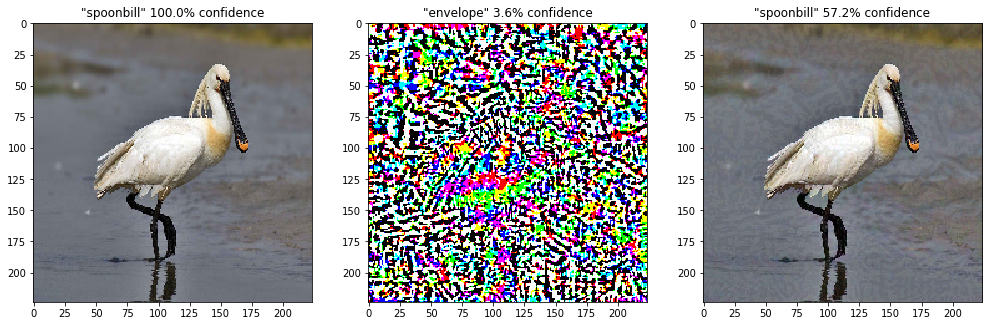

In [43]:
plt.figure(figsize = (17, 17))
plt.subplot(1, 3, 1)
plt.imshow(original_array[0])
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(perturbation[0])
plt.title(title_perturbation)
plt.subplot(1, 3, 3)
plt.imshow(deprocess_array[0])
plt.title(title_modified)

In [44]:
print('mean value of perturbation:', perturbation.mean())
pred = model.predict(modified_array)
print(*[p[1:] for p in decode_predictions(pred)[0]], sep = '\n')

mean value of perturbation: -0.02131165
('spoonbill', 0.57158744)
('pelican', 0.1829098)
('goose', 0.034351975)
('armadillo', 0.031545486)
('American_alligator', 0.027590742)
